In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

In [4]:
from one.utils import *
from one.data.ucrdata import UcrDataReader

In [5]:
ROOT_DIR = "./data/ucr/"
t = get_files_from_path("./data/ucr")

In [106]:
d = UcrDataReader()
test = d(ROOT_DIR+t[100])

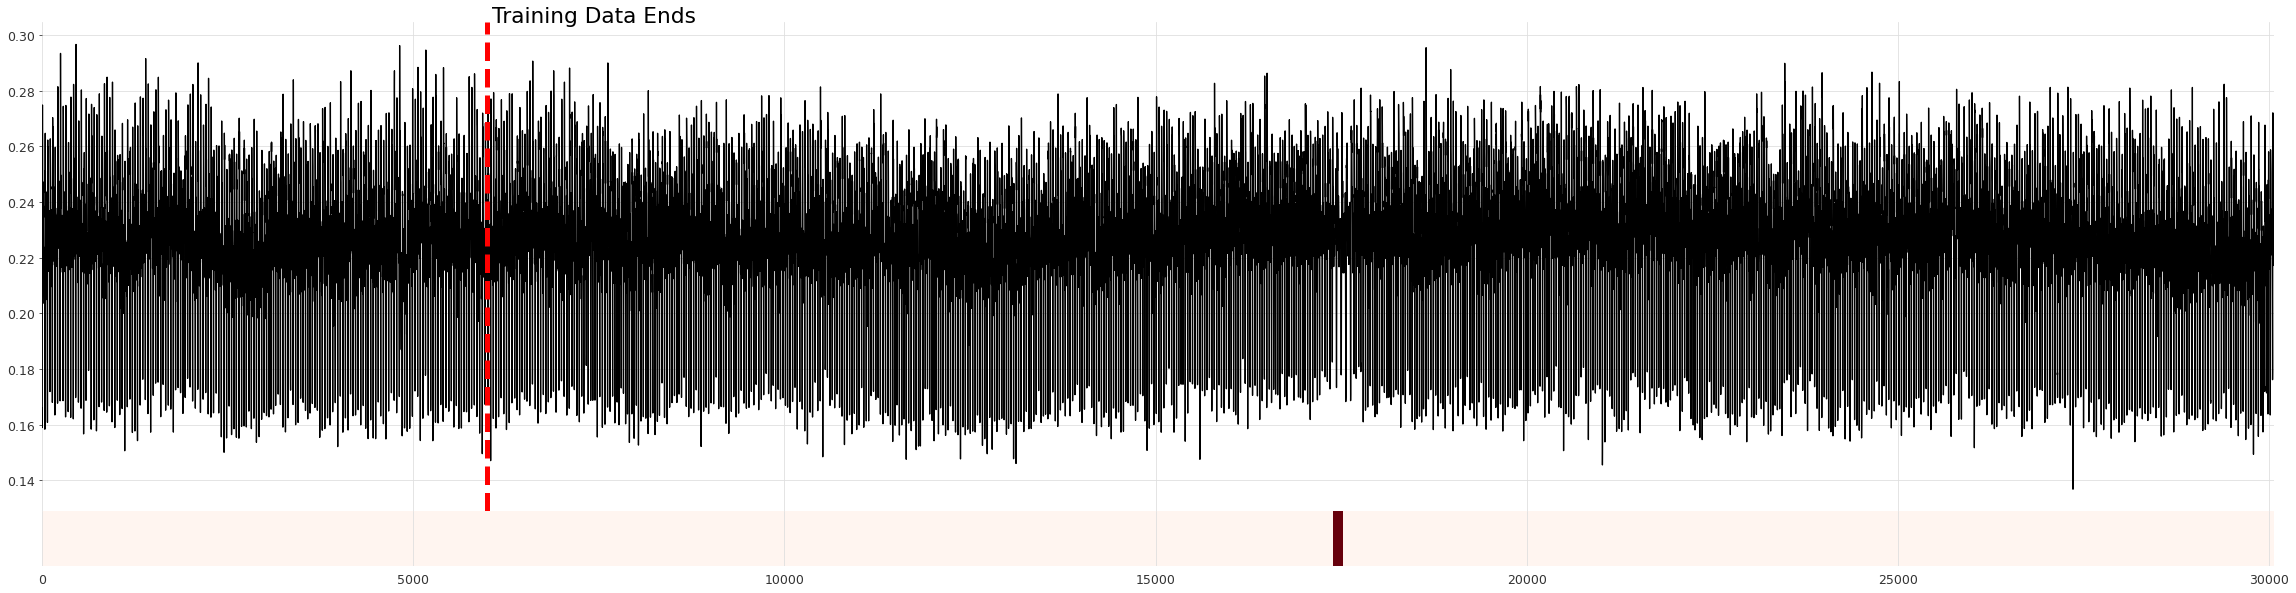

In [107]:
p = graph_data(test.series, test.labels, test.train_len)


In [8]:
tr_data, tr_label = test.train

In [9]:
from darts.models import ARIMA, FFT, StatsForecastAutoARIMA,RegressionModel, NBEATSModel
from darts.timeseries import TimeSeries
from numpy.lib.stride_tricks import sliding_window_view

2022-05-17 18:00:28 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [10]:
import warnings
warnings.filterwarnings('ignore')


In [11]:
from rich.progress import track, Progress

In [41]:
from darts.datasets import *
from darts.dataprocessing.transformers import Scaler

In [42]:
scaler = Scaler()

In [121]:
w = 500
s = 50

series = TimeSeries.from_values(test.series)
series = scaler.fit_transform(series)
series = series.pd_series().to_numpy().astype(np.float32)

full = series[test.train_len-w:]
full_window = sliding_window_view(full, w)
full_window = full_window[::s]

preds = np.array([])

In [122]:
series_b = HeartRateDataset().load().astype(np.float32)
series_c = TaylorDataset().load().astype(np.float32)


In [ ]:
model = NBEATSModel(w,s)


model.fit(TimeSeries.from_values(series[:int(test.train_len * 0.9)]), val_series = TimeSeries.from_values(series[int(test.train_len * 0.9):]), epochs=20)

[2022-05-18 10:37:09,035] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4851 samples.
[2022-05-18 10:37:09,035] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4851 samples.
2022-05-18 10:37:09 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 4851 samples.
[2022-05-18 10:37:09,232] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2022-05-18 10:37:09,232] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
2022-05-18 10:37:09 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 32-bits; casting model to float32.
2022-05-18 10:37:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-05-18 10:37:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-05-18 10:37:09 pytorc

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [112]:
with Progress() as progress:
    
    task1 = progress.add_task("Generating Predictions...", total=len(test.test[0])/s)

    for idx, arr in enumerate(full_window.astype(np.float32)):
        ts = TimeSeries.from_values(arr)
        p = model.predict(n=s, series=ts)

        preds = np.append(preds, p.pd_series().to_numpy())
        progress.update(task1, advance=1)

Output()

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

Predicting: 171it [00:00, ?it/s]

In [34]:
w = 500
s = 1


full = test.series[test.train_len-w:]
full_window = sliding_window_view(full, w)
full_window = full_window[::s]

preds = np.array([])

full_t = test.series[:test.train_len-w]

In [35]:
model = BATS()
model.fit(TimeSeries.from_values(full_t))

/Users/benjaminye/Library/Caches/pypoetry/virtualenvs/one-NMS3jTrz-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/benjaminye/Library/Caches/pypoetry/virtualenvs/one-NMS3jTrz-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [39]:
for idx, arr in enumerate(full_window):
    ts = TimeSeries.from_values(arr)
    p = model.historical_forecasts(ts, start=0.999)
    
    preds = np.append(preds, p.pd_series().to_numpy())
    print(f"on {idx+1} out of {len(full_window)}")


/Users/benjaminye/Library/Caches/pypoetry/virtualenvs/one-NMS3jTrz-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/benjaminye/Library/Caches/pypoetry/virtualenvs/one-NMS3jTrz-py3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
Process SpawnPoolWorker-25:
Process SpawnPoolWorker-26:


KeyboardInterrupt: 

In [113]:
preds.shape

(24100,)

In [101]:
preds = preds[:len(test.test[0])]

In [115]:
anom = np.absolute(preds[:len(test.test[0])] - series[test.train_len:])

In [116]:
anom.argmax()

21358

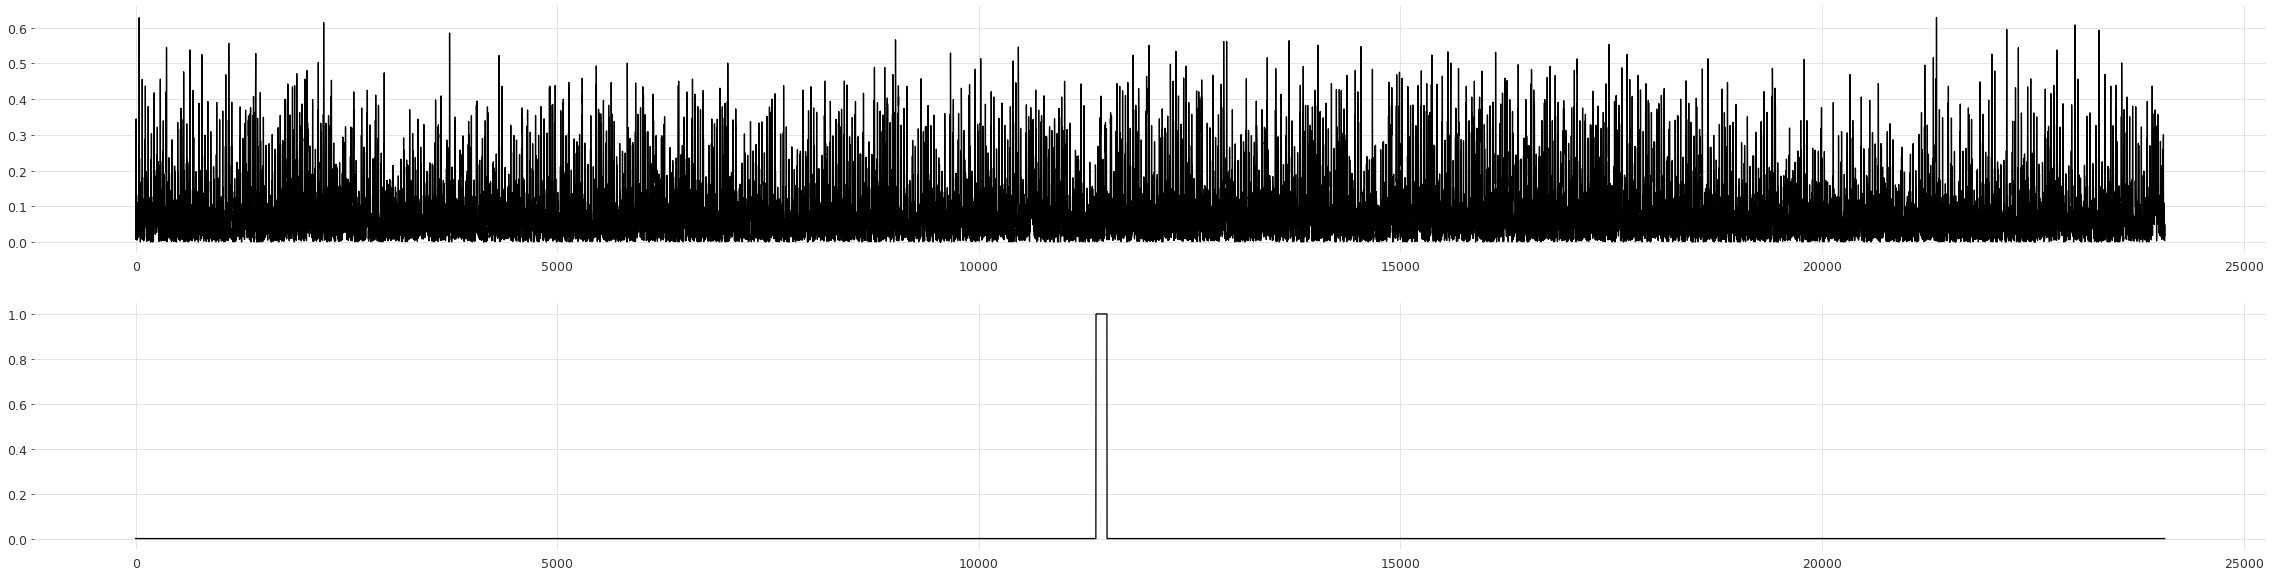

In [117]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(anom)
b.plot(test.test[1])
#a.plot(test.test[0])

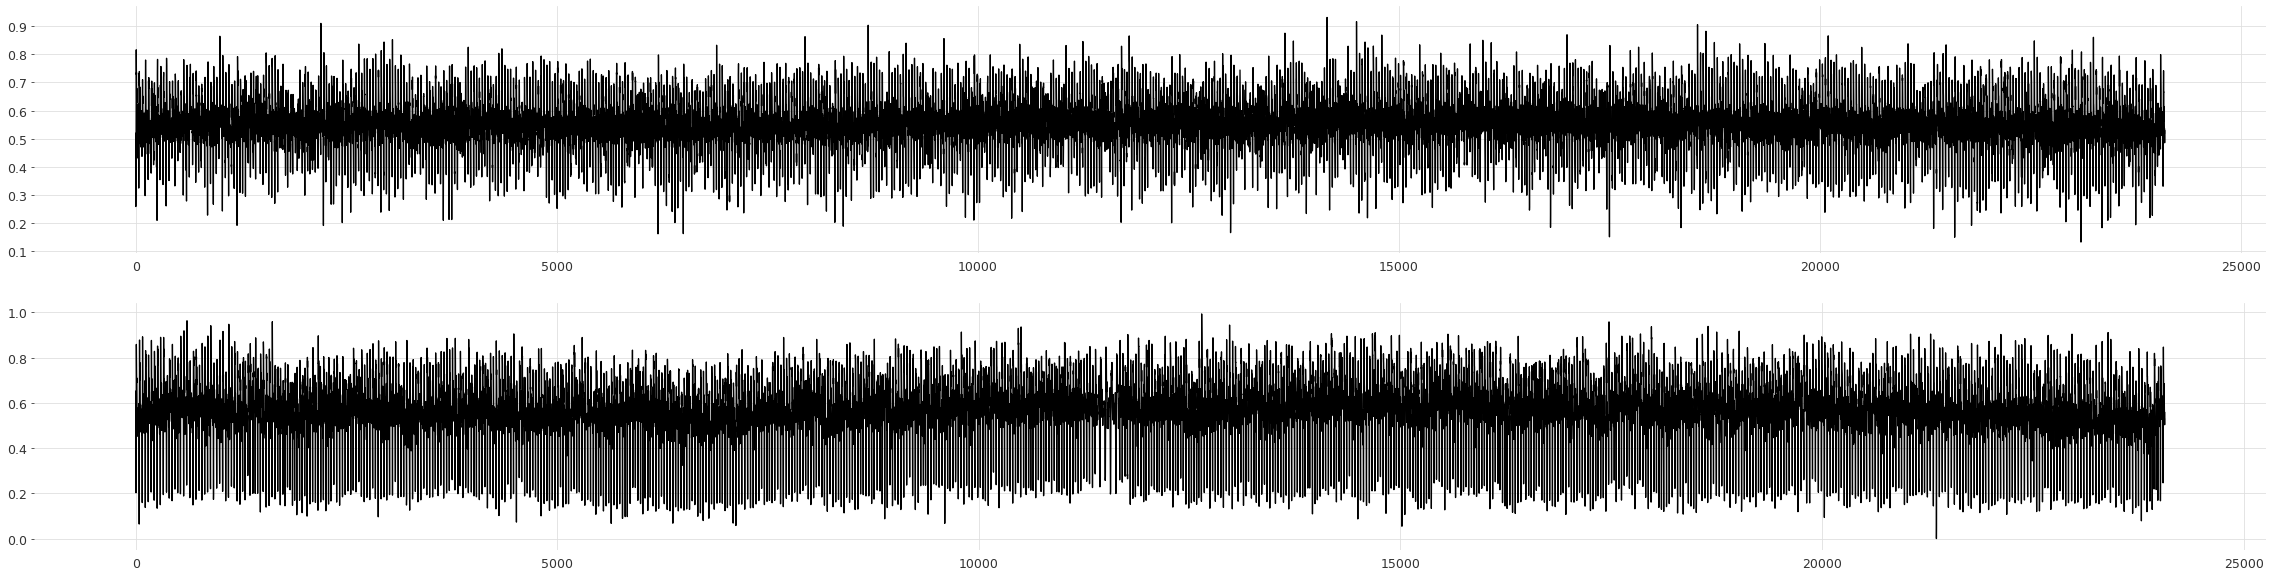

In [119]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(series[test.train_len:])

In [74]:
from numpy.lib.stride_tricks import sliding_window_view

In [81]:
v = sliding_window_view(test.train[0], 50, axis=0)

In [80]:
test.train[0]

array([15.542656, 14.262648, 13.578006, ..., 21.332439, 21.843922,
       22.026876])